# Intel Image Classification

By Aviya Oren and Maya Hayat

This Data contains around 25k images of size 150x150 distributed under 5 categories.
1. 'buildings'
2. 'forest'
3. 'mountain'
4. 'sea'
5. 'street'

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import random

import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

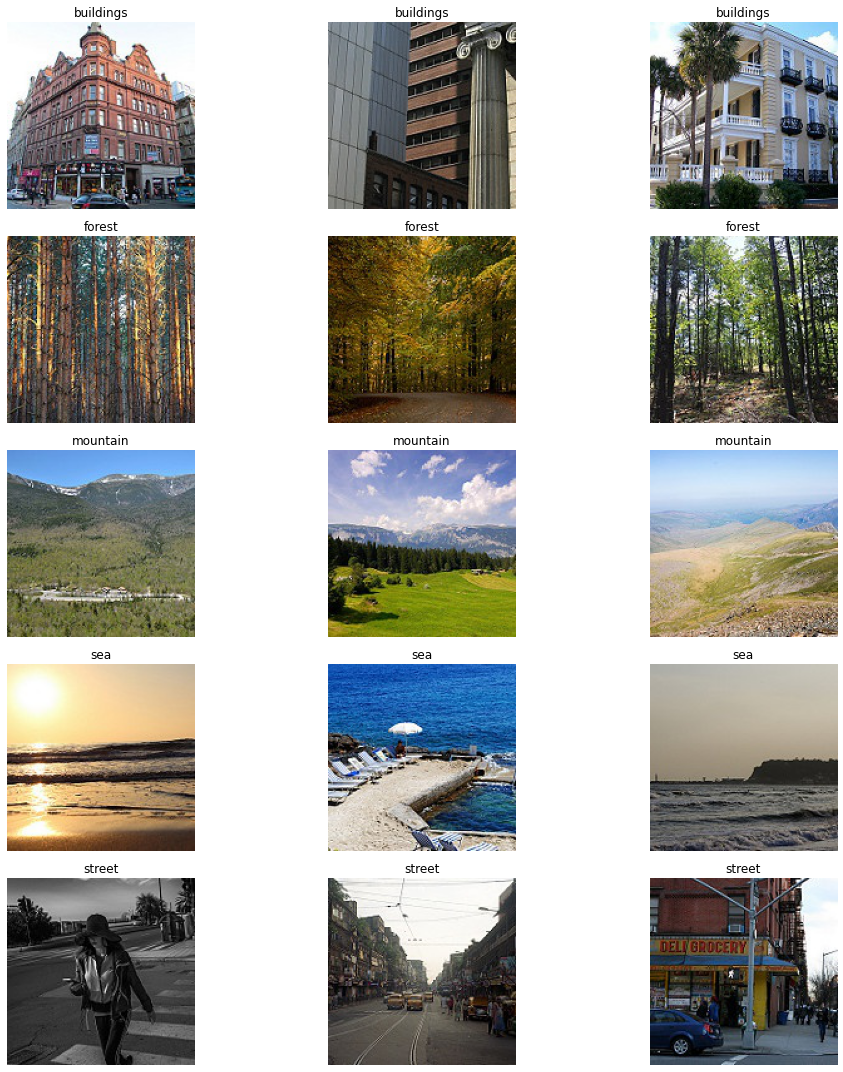

In [2]:
# Path to the directory containing the images
base_directory =  r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train'

# Categories
categories = ['buildings', 'forest', 'mountain', 'sea', 'street']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, 15))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()


In [3]:
data_directory = r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train'

In [4]:
test_data = r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_test\seg_test'

In [5]:
os.listdir(data_directory)

['buildings', 'forest', 'mountain', 'sea', 'street']

In [6]:
os.listdir(test_data)

['buildings', 'forest', 'mountain', 'sea', 'street']

In [7]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data = tf.keras.utils.image_dataset_from_directory(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_train\seg_train', image_size = (150,150), batch_size=128)

Found 11630 files belonging to 5 classes.


In [8]:
test = tf.keras.utils.image_dataset_from_directory(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\seg_test\seg_test', image_size = (150,150), batch_size=128)

Found 2447 files belonging to 5 classes.


In [9]:
data_iterator = data.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [10]:
batch = data_iterator.next()

In [11]:
batch[1]

array([2, 4, 3, 2, 4, 3, 2, 3, 1, 4, 3, 3, 2, 3, 0, 1, 4, 4, 2, 0, 1, 1,
       2, 2, 2, 0, 0, 0, 3, 1, 2, 3, 3, 2, 3, 0, 3, 0, 4, 0, 2, 4, 3, 1,
       2, 0, 4, 0, 1, 1, 3, 2, 4, 3, 0, 2, 0, 2, 2, 1, 3, 0, 1, 2, 0, 3,
       1, 2, 1, 4, 2, 2, 1, 2, 1, 4, 1, 2, 0, 3, 2, 2, 4, 4, 1, 0, 1, 1,
       3, 3, 0, 0, 1, 0, 3, 2, 2, 2, 4, 1, 2, 0, 3, 0, 1, 2, 0, 4, 4, 1,
       0, 1, 2, 0, 2, 3, 4, 4, 4, 3, 0, 0, 4, 4, 4, 2, 0, 2])

In [12]:
batch_test = test_iterator.next()

In [13]:
# where the first batch is our data and the second is the labels
len(batch),len(batch_test)

(2, 2)

In [14]:
batch[0].shape

(128, 150, 150, 3)

In [15]:
batch_test[0].shape

(128, 150, 150, 3)

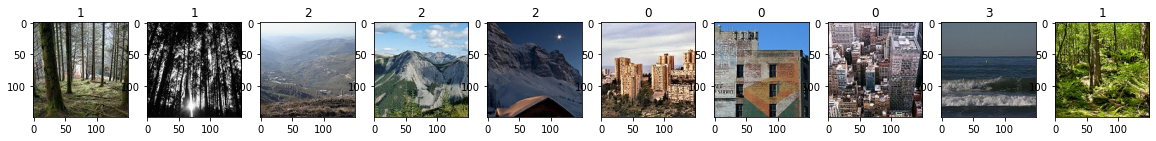

In [16]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
offset = 20
for idx, img in enumerate(batch[0][offset:offset+10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][offset+idx])

As we can see above the following numbers match the following catagories:

0. building
1. forest
2. mountain
3. sea
4. street

In [17]:
print("max:" , batch[0].max(), " and min: ", batch[0].min())

max: 255.0  and min:  0.0


In [18]:
data = data.map(lambda x, y: (x / 255.0, y))

In [19]:
test = test.map(lambda x, y: (x / 255.0, y))

In [20]:
data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [21]:
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.2)

In [22]:
print(train_size, val_size)

72 18


In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

In [24]:
# Number of batches * 32 images
len(train), len(val), len(test)

(72, 18, 20)

In [25]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

In [26]:
logdir = r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\Log'

In [27]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Combine the TensorBoard callback with the EarlyStopping callback
callbacks = [callback, early_stopping]

In [28]:
model= tf.keras.Sequential([
    # First layer
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third layer
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [29]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [31]:
history = model.fit(train, epochs=20, validation_data = val, callbacks=[callback])

Epoch 1/20
72/72 [==============================] - 165s 2s/step - loss: 0.9213 - accuracy: 0.6202 - val_loss: 0.7058 - val_accuracy: 0.7231
Epoch 2/20
72/72 [==============================] - 163s 2s/step - loss: 0.6487 - accuracy: 0.7411 - val_loss: 0.5562 - val_accuracy: 0.7804
Epoch 3/20
72/72 [==============================] - 164s 2s/step - loss: 0.5019 - accuracy: 0.8065 - val_loss: 0.5412 - val_accuracy: 0.8034
Epoch 4/20
72/72 [==============================] - 163s 2s/step - loss: 0.3994 - accuracy: 0.8498 - val_loss: 0.4343 - val_accuracy: 0.8398
Epoch 5/20
72/72 [==============================] - 169s 2s/step - loss: 0.3341 - accuracy: 0.8788 - val_loss: 0.4349 - val_accuracy: 0.8416
Epoch 6/20
72/72 [==============================] - 167s 2s/step - loss: 0.2613 - accuracy: 0.9077 - val_loss: 0.3446 - val_accuracy: 0.8724
Epoch 7/20
72/72 [==============================] - 169s 2s/step - loss: 0.2045 - accuracy: 0.9263 - val_loss: 0.3477 - val_accuracy: 0.8798
Epoch 8/20
72

In [32]:
model.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\first_model_without_glacier_5.h5')

C:\Users\Maya\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


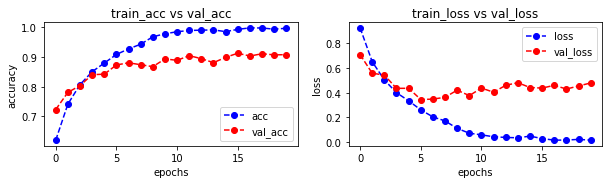

In [33]:
plot_accuracy_loss(history)

In [34]:
model = tf.keras.models.load_model(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\first_model_without_glacier_5.h5')

In [35]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 5)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])


1/1 [==============================] - 0s 94ms/step


In [36]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9403, Recall: 0.9557, Accuracy:0.8459


In [37]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


20/20 [==============================] - 7s 329ms/step - loss: 0.7738 - accuracy: 0.8459
Test Loss: 0.7738170027732849, Test Accuracy: 0.8459337949752808


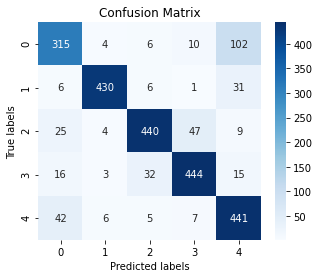

In [38]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Try to improve using VGG model

In [80]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Load the VGG16 base model
base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# # Freeze the layers in the base model
for layer in base_vgg.layers:
    layer.trainable = False

In [83]:
# Create the head model
x = Flatten()(base_model.output)
output = Dense(5, activation='softmax')(x) 

In [86]:
model_vgg = Model(inputs=base_model.input, outputs=output)

In [87]:
model_vgg.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [88]:
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [89]:
history_model_vgg = model_vgg.fit(train, epochs=15, validation_data = val, callbacks=[callback])

Epoch 1/15
72/72 [==============================] - 972s 14s/step - loss: 0.4268 - accuracy: 0.8505 - val_loss: 0.2713 - val_accuracy: 0.9002
Epoch 2/15
72/72 [==============================] - 1352s 19s/step - loss: 0.2287 - accuracy: 0.9205 - val_loss: 0.2931 - val_accuracy: 0.8859
Epoch 3/15
72/72 [==============================] - 1929s 27s/step - loss: 0.1807 - accuracy: 0.9360 - val_loss: 0.2193 - val_accuracy: 0.9180
Epoch 4/15
72/72 [==============================] - 1742s 24s/step - loss: 0.1548 - accuracy: 0.9495 - val_loss: 0.1960 - val_accuracy: 0.9284
Epoch 5/15
72/72 [==============================] - 1748s 24s/step - loss: 0.1297 - accuracy: 0.9599 - val_loss: 0.1875 - val_accuracy: 0.9288
Epoch 6/15
72/72 [==============================] - 4345s 61s/step - loss: 0.1181 - accuracy: 0.9635 - val_loss: 0.1800 - val_accuracy: 0.9332
Epoch 7/15
72/72 [==============================] - 4650s 65s/step - loss: 0.1034 - accuracy: 0.9708 - val_loss: 0.1732 - val_accuracy: 0.9388


In [91]:
model_vgg.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_basic_model.h5')

C:\Users\Maya\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


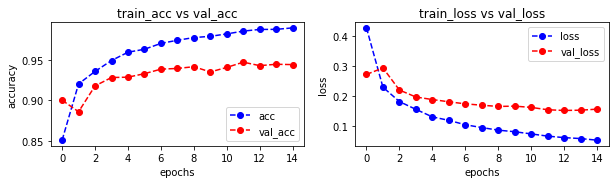

In [90]:
plot_accuracy_loss(history_model_vgg)

In [92]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 5)
    acc.update_state(y_true_one_hot, yhat)

1/1 [==============================] - 1s 1s/step


In [94]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9753, Recall: 0.9816, Accuracy:0.9228


In [96]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


20/20 [==============================] - 157s 8s/step - loss: 0.2074 - accuracy: 0.9228
Test Loss: 0.20739680528640747, Test Accuracy: 0.9227625727653503


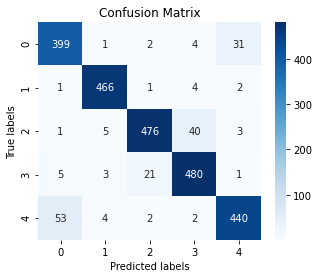

In [97]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Try to improve the VGG model

In [51]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense

# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# # Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [52]:
# Create the head model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(5, activation='softmax')(x) 

In [53]:
# Combine the base and head models
model_vgg_impr = Model(inputs=base_model.input, outputs=output)

In [54]:
# Compile the model
model_vgg_impr.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model_vgg_impr.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [55]:
history_vgg_impr = model_vgg_impr.fit(train, epochs=15, validation_data = val, callbacks=[callbacks])

Epoch 1/15
72/72 [==============================] - 780s 11s/step - loss: 0.3720 - accuracy: 0.8609 - val_loss: 0.2323 - val_accuracy: 0.9102
Epoch 2/15
72/72 [==============================] - 648s 9s/step - loss: 0.1707 - accuracy: 0.9399 - val_loss: 0.1943 - val_accuracy: 0.9310
Epoch 3/15
72/72 [==============================] - 688s 10s/step - loss: 0.1216 - accuracy: 0.9581 - val_loss: 0.1753 - val_accuracy: 0.9388
Epoch 4/15
72/72 [==============================] - 652s 9s/step - loss: 0.0903 - accuracy: 0.9701 - val_loss: 0.1673 - val_accuracy: 0.9414
Epoch 5/15
72/72 [==============================] - 637s 9s/step - loss: 0.0738 - accuracy: 0.9758 - val_loss: 0.1570 - val_accuracy: 0.9440
Epoch 6/15
72/72 [==============================] - 654s 9s/step - loss: 0.0523 - accuracy: 0.9861 - val_loss: 0.2532 - val_accuracy: 0.9106
Epoch 7/15
72/72 [==============================] - 1035s 14s/step - loss: 0.0456 - accuracy: 0.9872 - val_loss: 0.1568 - val_accuracy: 0.9492
Epoch 8/1

In [56]:
model_vgg_impr.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model_impr_withoutglacier_5.h5')

C:\Users\Maya\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [182]:
model_vgg_impr = tf.keras.models.load_model(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model_impr_withoutglacier_5.h5')

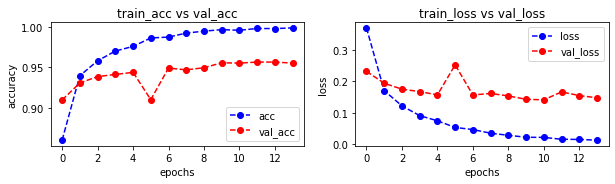

In [57]:
plot_accuracy_loss(history_vgg_impr)

In [58]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg_impr.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 5)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])
    


1/1 [==============================] - 1s 939ms/step


In [59]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9720, Recall: 0.9831, Accuracy:0.9228


In [60]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg_impr.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


20/20 [==============================] - 143s 7s/step - loss: 0.2755 - accuracy: 0.9228
Test Loss: 0.27549105882644653, Test Accuracy: 0.9227625727653503


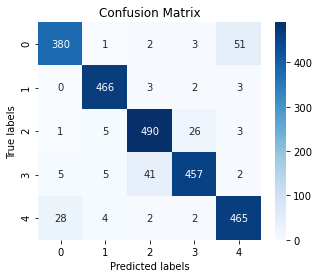

In [61]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

We can see a slight confusion between the building and street which is due to their similarities (even a human eye would have a hard time classifying some of the images presented). 
The other main confusion though is between the mountains and see which caused by the fact that they probabily both consisting of a lot of blue thereofore the model might have a difficulty classifying those 2.

# Fine tuning VGG16 model

In [62]:
# Load the VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# # Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [63]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [64]:
# Create the head model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(5, activation='softmax')(x) 

In [65]:
# Combine the base and head models
model_vgg_fine_tuned = Model(inputs=base_model.input, outputs=output)

In [66]:
import tensorflow as tf

# Define initial learning rate
initial_learning_rate = 0.0001

# Define decay rate and decay steps
decay_rate = 0.95  # Example decay rate (experiment with different values)
decay_steps = 30  # Example decay steps (adjust based on your training regime)

# Create the learning rate decay schedule
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_rate=decay_rate,
    decay_steps=decay_steps,
    staircase=True  # Set to True for discrete decay at each step
)


In [68]:
# Compile the model
model_vgg_fine_tuned.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [69]:
# Print model summary
model_vgg_fine_tuned.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [70]:
history_vgg_fine_tuned = model_vgg_fine_tuned.fit(train, epochs=15, validation_data = val, callbacks=[callbacks])

Epoch 1/15
72/72 [==============================] - 1389s 19s/step - loss: 0.3322 - accuracy: 0.8797 - val_loss: 0.2339 - val_accuracy: 0.9145
Epoch 2/15
72/72 [==============================] - 707s 10s/step - loss: 0.1659 - accuracy: 0.9405 - val_loss: 0.2276 - val_accuracy: 0.9175
Epoch 3/15
72/72 [==============================] - 693s 10s/step - loss: 0.1240 - accuracy: 0.9569 - val_loss: 0.1813 - val_accuracy: 0.9379
Epoch 4/15
72/72 [==============================] - 37648s 530s/step - loss: 0.0900 - accuracy: 0.9692 - val_loss: 0.1693 - val_accuracy: 0.9410
Epoch 5/15
72/72 [==============================] - 737s 10s/step - loss: 0.0768 - accuracy: 0.9744 - val_loss: 0.1702 - val_accuracy: 0.9431
Epoch 6/15
72/72 [==============================] - 754s 10s/step - loss: 0.0542 - accuracy: 0.9833 - val_loss: 0.1558 - val_accuracy: 0.9484
Epoch 7/15
72/72 [==============================] - 734s 10s/step - loss: 0.0383 - accuracy: 0.9911 - val_loss: 0.1606 - val_accuracy: 0.9505
Ep

In [73]:
model_vgg_fine_tuned.save(r'C:\Users\Maya\OneDrive\Desktop\Intel_Images\vgg_model_impr_fine_tuned_5.h5')

C:\Users\Maya\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


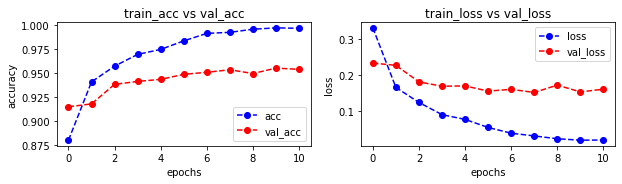

In [74]:
plot_accuracy_loss(history_vgg_fine_tuned)

In [75]:
from tensorflow.keras.metrics import CategoricalAccuracy

pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

y_true_all = []
y_pred_all = []

for batch_test in test.as_numpy_iterator():
    X, y = batch_test
    yhat = model_vgg_fine_tuned.predict(X, batch_size=128)
    y_pred = np.argmax(yhat,axis=1)
    pre.update_state(y, y_pred)
    re.update_state(y, y_pred)
    y_true_one_hot = tf.one_hot(y, 5)
    acc.update_state(y_true_one_hot, yhat)
    y_true_all = np.concatenate([y_true_all, y])
    y_pred_all = np.concatenate([y_pred_all, y_pred])
    


1/1 [==============================] - 1s 869ms/step


In [76]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy:{:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.9809, Recall: 0.9701, Accuracy:0.9240


In [78]:
# Use the appropriate evaluation metric for your task (e.g., accuracy, precision, recall)
model_loss, model_accuracy = model_vgg_fine_tuned.evaluate(test)
print(f"Test Loss: {model_loss}, Test Accuracy: {model_accuracy}")


20/20 [==============================] - 125s 6s/step - loss: 0.2645 - accuracy: 0.9240
Test Loss: 0.2644931375980377, Test Accuracy: 0.9239885807037354


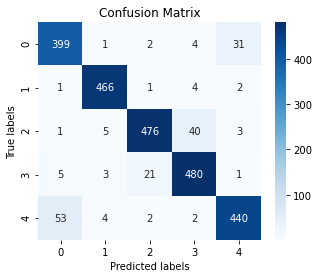

In [79]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()